# Extracting QoS metrics from packet captures

## PySpark setup

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
from collections import defaultdict

In [2]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, IntegerType, DoubleType, LongType, BooleanType

In [3]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", '4G') \
    .config("spark.ui.killEnabled", False) \
    .getOrCreate()
spark.sparkContext.setLogLevel('OFF')

22/05/13 09:00:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df = spark.read.parquet("data/0.parquet").cache()

In [5]:
df.show(n=5)

+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+----------+----------+-----------+--------+------------+------------+------+
|                  ts|          sIP|sPort|          dIP|dPort|ip_len|ip_hdr_len|ip_proto|tcp_flags|   tcp_seq|   tcp_ack|tcp_hdr_len|tcp_rwnd|tls_hostname|dns_hostname|dns_ip|
+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+----------+----------+-----------+--------+------------+------------+------+
|1.6492352223069434E9|192.168.100.1|   80|192.168.1.103|51038|   982|        20|       6|       24|2447701223|1141693581|         20|     919|        null|        null|  null|
|1.6492352223069568E9|192.168.1.103|51038|192.168.100.1|   80|    40|        20|       6|       16|1141693581|2447702165|         20|     884|        null|        null|  null|
|1.6492352224897146E9|52.117.209.84|   80|192.168.1.103|34356|    64|        20|       6|       24|1035282501| 732296266

In [6]:
df.count()

24399

## Finding YouTube flows

googlevideo.com is the domain owned by google used to store videos for YouTube.

In [7]:
df.select('dns_ip', 'dns_hostname').distinct().filter(
    df.dns_hostname.contains('googlevideo')).show(truncate=False)

+-------------+-----------------------------------------------------------------------+
|dns_ip       |dns_hostname                                                           |
+-------------+-----------------------------------------------------------------------+
|184.21.61.208|rr5.sn-8p5n5u-525e.googlevideo.com                                     |
|184.21.61.208|rr5---sn-8p5n5u-525e.googlevideo.com,rr5.sn-8p5n5u-525e.googlevideo.com|
+-------------+-----------------------------------------------------------------------+



## Finding the Host IP

In [8]:
df.groupby('dIP').agg({'ip_len': 'sum', '*': 'count'}).sort('sum(ip_len)', ascending=False).show(n=3)

+-------------+--------+-----------+
|          dIP|count(1)|sum(ip_len)|
+-------------+--------+-----------+
|192.168.1.103|   14996|   24315442|
|184.21.61.208|    3962|     197986|
|34.104.35.123|    4522|     184043|
+-------------+--------+-----------+
only showing top 3 rows



## Available flows for the video streaming session

A video streaming session consists of multiple flows. Let's isolate the biggest flow

In [9]:
df.filter((df.sIP=='184.21.61.208') & (df.dIP == '192.168.1.103')).groupby(
    'sIP', 'sPort', 'dIP', 'dPort', 'ip_proto').agg(
    {'ip_len': 'sum', '*': 'count'}).sort(
    'sum(ip_len)', ascending=False).show(n=7)

+-------------+-----+-------------+-----+--------+--------+-----------+
|          sIP|sPort|          dIP|dPort|ip_proto|count(1)|sum(ip_len)|
+-------------+-----+-------------+-----+--------+--------+-----------+
|184.21.61.208|  443|192.168.1.103|45470|       6|    4194|    7134669|
|184.21.61.208|  443|192.168.1.103|45468|       6|    2424|    4243551|
|184.21.61.208|  443|192.168.1.103|45536|       6|       2|         92|
+-------------+-----+-------------+-----+--------+--------+-----------+



## Constants and Functions

In [11]:
def get_flow_df(host_ip, host_port, yt_ip, yt_port, ip_proto):
    flow_df = df.filter((((df.sIP == yt_ip) & (df.dIP == host_ip) & 
                          (df.sPort == yt_port) & (df.dPort == host_port)) | 
                         ((df.sIP == host_ip) & (df.dIP == yt_ip) & 
                          (df.sPort == host_port) & (df.dPort == yt_port))) &
                        (df.ip_proto == ip_proto)) \
                .sort('ts')
    flow_df = flow_df.withColumn('idx', F.row_number().over(Window().orderBy('ts')))
    flow_df = flow_df.withColumn('is_up', (flow_df.sIP == host_ip).cast(BooleanType()))
    flow_df = flow_df.withColumn('payload_size', 
                                 (flow_df.ip_len - flow_df.tcp_hdr_len - flow_df.ip_hdr_len).cast(IntegerType()))
    flow_df = flow_df.withColumn('tcp_len',
                                 (flow_df.ip_len - flow_df.ip_hdr_len).cast(IntegerType()))
    return flow_df

In [12]:
get_flow_df('192.168.1.103', 45470, '184.21.61.208', 443, 6).show(n=3)

+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+---------+---------+-----------+--------+------------+------------+------+---+-----+------------+-------+
|                  ts|          sIP|sPort|          dIP|dPort|ip_len|ip_hdr_len|ip_proto|tcp_flags|  tcp_seq|  tcp_ack|tcp_hdr_len|tcp_rwnd|tls_hostname|dns_hostname|dns_ip|idx|is_up|payload_size|tcp_len|
+--------------------+-------------+-----+-------------+-----+------+----------+--------+---------+---------+---------+-----------+--------+------------+------------+------+---+-----+------------+-------+
| 1.649235222948141E9|192.168.1.103|45470|184.21.61.208|  443|  1500|        20|       6|       16|171068669|215377161|         20|    2558|        null|        null|  null|  1| true|        1460|   1480|
|1.6492352229481466E9|192.168.1.103|45470|184.21.61.208|  443|   491|        20|       6|       24|171070129|215377161|         20|    2558|        null|        null|  null|  2| tr

## Transport Layer QoS metrics

The metrics we compute in today's section:
1. Receive Window size (upstream and downstream)
2. Bytes per packet (upstream and downstream)
3. RTT (upstream only)
4. Number of Retransmissions (upstream only)
5. Number of Duplicate ACKs (upstream and downstream)
6. Goodput (upstream and downstream)

In [13]:
class PlotData:
    
    def __init__(self):
        self.rwnd_data = []
        self.bytes_per_pkt_data = []
        self.rtt_data = []
        self.retransmission_data = []
        self.dup_acks_data = []
        self.goodput_data = []
        self.data = [self.rwnd_data, self.bytes_per_pkt_data, self.rtt_data, 
                self.retransmission_data, self.dup_acks_data, self.goodput_data]
        
    def display(self):
        for d in self.data:
            labels = list(d[0].keys())
            for l in labels:
                v = [x[l] for x in d]
                print(f'{l}: {v}')
        return

In [14]:
def get_l4_metrics(flow_df, metric_window):
    plot_data = PlotData()
    rwnd_data = plot_data.rwnd_data
    bytes_per_pkt_data = plot_data.bytes_per_pkt_data
    rtt_data = plot_data.rtt_data
    retransmission_data = plot_data.retransmission_data
    dup_acks_data = plot_data.dup_acks_data
    goodput_data = plot_data.goodput_data
    
    # for computing rtt
    send_times = {}
    # for computing retransmissions
    last_byte_sent = -math.inf
    # for dup acks
    ack_ctr_dict_up = defaultdict(int)
    ack_ctr_dict_down = defaultdict(int)
    
    def add_new_record():
        rwnd_data.append({'rwnd_up': [], 'rwnd_down': []})
        bytes_per_pkt_data.append({'bytes_up': [], 'bytes_down': []})
        rtt_data.append({'rtt_up': []})
        retransmission_data.append({'rtrm_up': 0})
        dup_acks_data.append({'dup_acks_up': 0, 'dup_acks_down': 0})
        goodput_data.append({'goodput_up': 0, 'goodput_down': 0})
        
        return
    
    def update_curr_record(start_ts, end_ts):
        nonlocal ack_ctr_dict_up, ack_ctr_dict_down
        for k in goodput_data[-1].keys():
            goodput_data[-1][k] /= (end_ts - start_ts)
        for k in bytes_per_pkt_data[-1].keys():
            bytes_per_pkt_data[-1][k] = np.mean(bytes_per_pkt_data[-1][k]).item()
        for k in rwnd_data[-1].keys():
            rwnd_data[-1][k] = np.mean(rwnd_data[-1][k]).item()
        for k in rtt_data[-1].keys():
            rtt_data[-1][k] = np.mean(rtt_data[-1][k]).item()
        
        dup_acks_data[-1]['dup_acks_up'] = len([1 for v in ack_ctr_dict_up.values() if v >= 3])
        dup_acks_data[-1]['dup_acks_down'] = len([1 for v in ack_ctr_dict_down.values() if v >= 3])
        ack_ctr_dict_up = defaultdict(int)
        ack_ctr_dict_down = defaultdict(int)
        return
    
    add_new_record()
    start_time = -1
    for row in flow_df.collect():
        if start_time == -1:
            start_time = row.ts
        if row.ts - start_time >= metric_window:
            update_curr_record(start_time, row.ts)
            start_time = row.ts
            add_new_record()
        is_syn = row.tcp_flags == 2
        is_synack = row.tcp_flags == 18
        is_ack = row.tcp_flags == 16
        is_pshack = row.tcp_flags == 24
        is_fin = row.tcp_flags == 1
        is_finack = row.tcp_flags == 17
        is_rst = (row.tcp_flags & 4) != 0
        is_urg = (row.tcp_flags & 32) != 0
        
        is_upstream = row.is_up
        is_downstream = not is_upstream
        
        sn = row.tcp_seq
        an = row.tcp_ack
        segment_size = row.payload_size
        
        if is_upstream and is_syn:
            send_times[sn+1] = row.ts
            last_byte_sent = 0
        elif is_upstream and not is_syn:
            if sn < last_byte_sent:
                retransmission_data[-1]['rtrm_up'] += 1
            if segment_size != 0:
                last_byte_sent = sn + segment_size - 1
                send_times[sn+segment_size] = row.ts
        elif is_downstream and (is_ack or is_pshack or is_synack):
            if an in send_times:
                rtt_data[-1]['rtt_up'].append(row.ts - send_times[an])
        
        if is_upstream and (is_ack or is_pshack or is_synack):
            ack_ctr_dict_up[an] += 1
        elif is_downstream and (is_ack or is_pshack or is_synack):
            ack_ctr_dict_up[an] += 1
        
        if segment_size > 0:
            k = 'goodput_up' if is_upstream else 'goodput_down'
            goodput_data[-1][k] += segment_size
        
        k = 'bytes_up' if is_upstream else 'bytes_down'
        bytes_per_pkt_data[-1][k].append(row.tcp_len)
        
        k = 'rwnd_up' if is_upstream else 'rwnd_down'
        rwnd_data[-1][k].append(row.tcp_rwnd)
    
    return plot_data

In [15]:
flow1 = get_flow_df('192.168.1.103', 45470, '184.21.61.208', 443, 6)
plot_data1 = get_l4_metrics(flow1, 0.5)

/Users/rohan/miniconda3/envs/spark/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rohan/miniconda3/envs/spark/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plotting

In [16]:
def change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=False, is_y_log=False):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if is_x_log:
        ax.set_xscale('log')
    if is_y_log:
        ax.set_yscale('log')
    if Xmin is not None:
        ax.set_xlim(xmin=Xmin)
    if Xmax is not None:
        ax.set_xlim(xmax=Xmax)
    ax.grid(True)
    return

def get_color_and_linestyle_kwargs(i):
    color_n = ['r', 'b', 'k', 'g', 'm', 'c', 'y']
    linestyles = ['-', '--', ':', '-.']
    return {'color': color_n[i % len(color_n)], 'linestyle': linestyles[i % len(linestyles)]}

def plotCDF(ax, data, labels, xlabel, ylabel, Xmax=None, Xmin=None, log_scale=False,
            set_legend=True, color_n_linestyle_dicts=None):
    raw = {}
    markers = ['o', '*', '^', '1', '4', 's', 'd', '3', 'd', 'o', '*', '^']

    for key in sorted(labels):
        raw[key] = list(data[key])
        if len(raw[key]) == 0:
            continue

        elms, cts = np.unique(raw[key], return_counts=True)
        cdf = np.cumsum(cts)
        cdf = cdf / cdf[-1]
        kwargs_dict = (get_color_and_linestyle_kwargs(key) if color_n_linestyle_dicts is None
                       else color_n_linestyle_dicts[key])
        ax.step(list(elms[:1]) + list(elms), [0] + list(cdf), where='post',
                label=labels[key], **kwargs_dict)

    # pl.legend((p),legnd,'lower right')
    if len(labels) > 1 and set_legend:
        set_legend_to_right(ax)

    change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=log_scale)
    ax.set_ylim(ymax=1.0)
    ax.set_ylim(ymin=0.0)

#### Cumulative Distribution Function (CDF)

In [17]:
def cdf_plots(plot_data):
    for data in plot_data.data:
        labels = list(data[0].keys())
        for label in labels:
            values = [d[label] for d in data if not isinstance(d[label],list)]
            plotCDF(plt.gca(), {0: values}, {0: ''}, label, 'CDF')
            plt.show()
    return

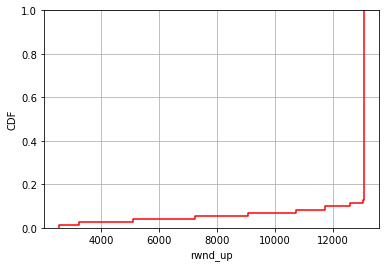

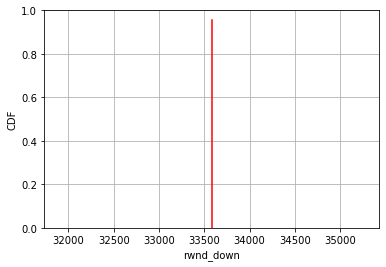

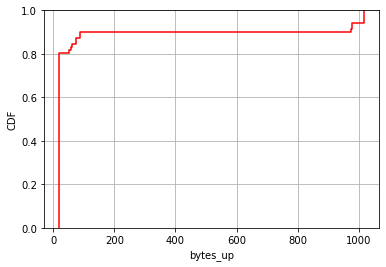

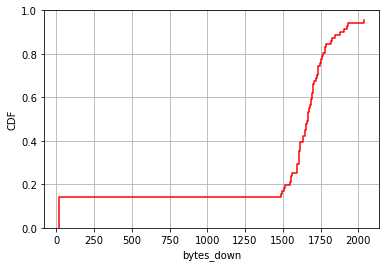

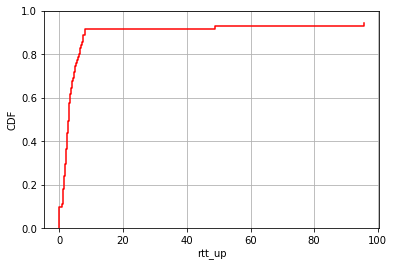

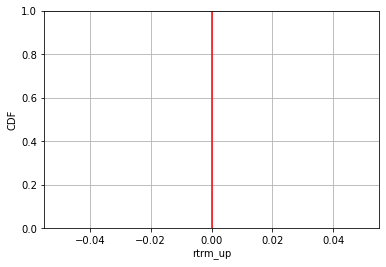

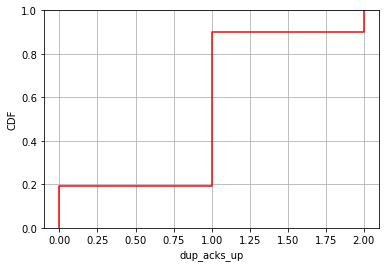

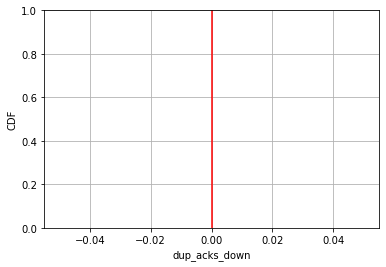

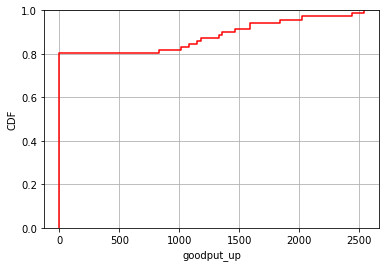

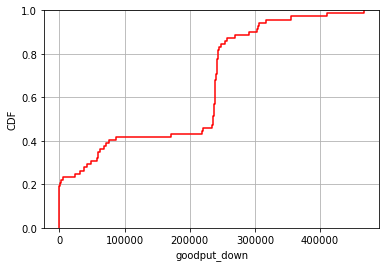

In [18]:
cdf_plots(plot_data1)

### Line plot

In [19]:
def line_plots(plot_data):
    for data in plot_data.data:
        labels = list(data[0].keys())
        for label in labels:
            values = [d[label] for d in data if not isinstance(d[label],list)]
            plt.plot(values, **get_color_and_linestyle_kwargs(0))
            change_plot_params(plt.gca(), 'Window ID', label, None, None, is_x_log=False, is_y_log=False)
            plt.show()
    return

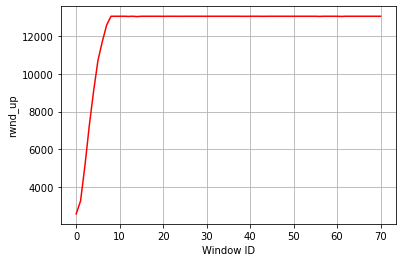

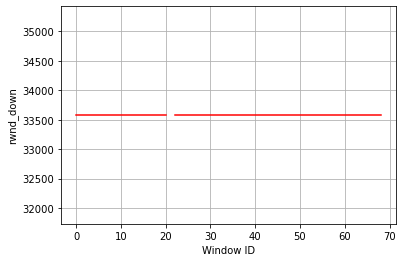

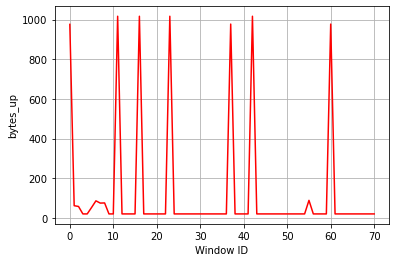

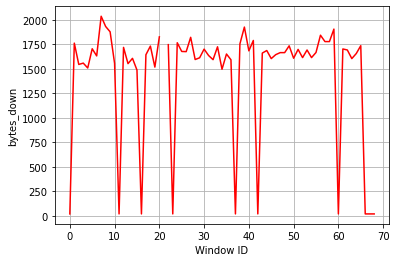

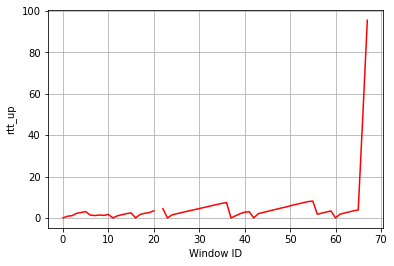

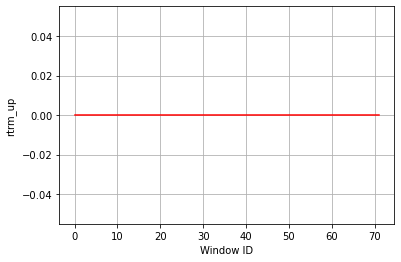

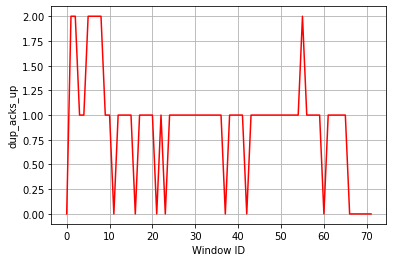

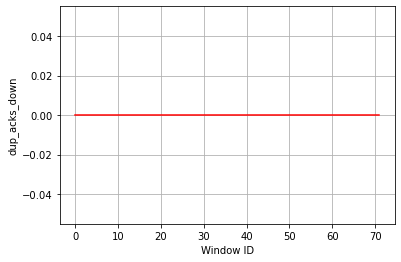

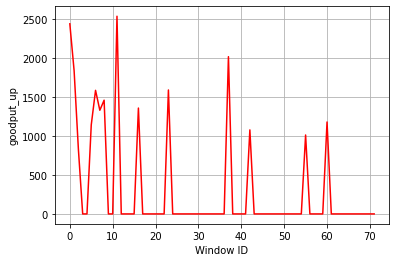

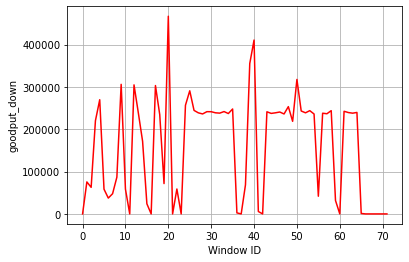

In [20]:
line_plots(plot_data1)